In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import pandas as pd
#Load the train and validation sets
train_df=pd.read_csv("./vaccine_train_set.csv",index_col=0)
val_df=pd.read_csv("./vaccine_validation_set.csv",index_col=0)

In [2]:
#Checks that there aren't any null values
print(train_df.head())
print(train_df.shape)
print(train_df.isnull().sum())
#print the portion of each class for the train set
print(train_df.groupby("label").count())

                                               tweet  label
0  Sip N Shop Come thru right now #Marjais #Popul...      0
1  I don't know about you but My family and I wil...      1
2  @MSignorile Immunizations should be mandatory....      2
3  President Obama spoke in favor of vaccination ...      0
4  "@myfoxla: Arizona monitoring hundreds for mea...      0
(15976, 2)
tweet    0
label    0
dtype: int64
       tweet
label       
0       7458
1       2073
2       6445


In [3]:
#Checks that there aren't any null values
print(val_df.head())
print(val_df.shape)
print(val_df.isnull().sum())
#print the portion of each class for the validation set
print(val_df.groupby("label").count())

                                               tweet  label
0  @user They had a massive surge in with covid d...      1
1  Required vaccines for school: Parents and guar...      0
2  “@KCStar: Two more Johnson County children hav...      0
3  NV can do better. Which states are the best (a...      2
4  Nothing like killing ourselves w/ our own fear...      2
(2282, 2)
tweet    0
label    0
dtype: int64
       tweet
label       
0       1065
1        296
2        921


In [4]:
import numpy as np
#open the pretrained embendings
Glove_file=open('glove.twitter.27B.200d.txt',encoding="utf8")
glove_vectors=dict()

#load the pretrain embedings to use them
for line in Glove_file:

    values=line.split()
    word=values[0]
    vectors=np.asarray(values[1:]).astype(np.float64)
    glove_vectors[word]=vectors

Glove_file.close()
#save them into a dictionary with form=> word(key): vector_with_shape(200,1) (value)
print(len(glove_vectors.keys()))

1193514


In [5]:
#Example: Print an embending of the word "woah"
print(glove_vectors["woah"])

[ 0.35049   -0.092346  -0.21949   -0.082786  -0.33759   -0.313
  0.75483   -0.045466  -0.16005    0.1852     0.049366   0.16048
  0.078113  -0.16777   -0.017527   0.32436    0.55093    0.18986
  0.17321   -0.26016    0.2022     0.20981    0.27178   -0.21254
 -0.21969    1.1221    -0.38136   -0.2081     0.18409   -0.47501
  0.27519   -0.051902  -0.034876  -0.31578   -0.29349    0.28474
 -0.077157  -0.42709   -0.050599  -0.51074    0.34047   -0.057103
 -0.087408   0.027009  -0.26078   -0.10273    1.1167     0.39918
 -0.55439    1.0249    -0.1998    -0.26164   -0.43768   -0.49712
  0.25035    0.12851    0.2093    -0.42327   -0.36178   -0.22508
  0.15384    0.28213    0.0079844 -0.2828    -0.23619    0.41811
 -0.11467    0.55878    0.10266    0.01856    0.31456    0.57663
 -0.00869    0.12738   -0.34583    0.2507     0.49821    0.20216
 -0.12245    0.19284    0.077367   0.078366  -0.45167    0.010687
  0.31628   -0.58084   -0.29625   -0.31293   -0.087788  -0.11117
  0.3828     0.056562  -0

In [6]:
#function to remove the emojis fron a string
#This will be used for the cleance of the tweets
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

In [7]:
# Prepare stopword list
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import TreebankWordTokenizer
import string
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords as sw

#cleance the tweets and tokenize them
def cleance_tokenizer(my_df):
    custom_stopwords=sw.words('english')
    #Cleaning
    #The 2 lines below is the code where I remove the links, the stopwords, and the punctuations from train set
    #remove links
    my_df["Filtered_words"]=my_df["tweet"].apply(lambda row:re.sub(r'http\S+', '', row))
    #custom punctuation
    my_punct=string.punctuation.replace("'","")
    #remove punctuation and make all the leters lowercase
    my_df["Filtered_words"]=my_df['Filtered_words'].apply(lambda x: ' '.join([word.translate(str.maketrans('', '', string.punctuation)).lower() for word in word_tokenize(x) if word not in (custom_stopwords)]))
    #remove digits
    my_df["Filtered_words"]=my_df["Filtered_words"].apply(lambda x: re.sub(r'\d+', '', x))
    #remove emojis
    my_df["Filtered_words"]=my_df["Filtered_words"].apply(lambda x:deEmojify(x))
    #tokenize the filtered words
    my_df['token_words']=my_df['Filtered_words'].apply(lambda x: TreebankWordTokenizer().tokenize(x))
    my_df.head()

cleance_tokenizer(train_df)
cleance_tokenizer(val_df)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mikem\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mikem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
import numpy as np

# the function that will take the previous tokenized words and take the mean of the pre-trained embending of the words that consists the tweet
def tweets_to_vectors(tweets_set,dim):
    #tweets_set=tweets_set.apply(lambda x: TreebankWordTokenizer().tokenize(x))
    tweets_vectors=[]
    #the total words on tweets that does not have an embending match
    count=0
    #the total words on tweets that have an embending match
    count_found=0
    #a set that keeps all the words that were matched with an already word that has a pretrained embending
    found_set=set()
    #set that keeps track of all the words which does not have a pretrained embending
    nt_found_set=set()
    for index, row in tweets_set.iteritems():
        #print(index,row)
        #words= TreebankWordTokenizer().tokenize(row)
        word_vectors=[]
        for w in row:
            vector=glove_vectors.get(w)
            if vector is not None:
                count_found+=1
                word_vectors.append(vector)
                found_set.add(w)
            else:
                count+=1
                word_vectors.append(np.zeros(dim))
                #print(w)
                nt_found_set.add(w)
        #print(word_vectors)
        tweets_vectors.append([np.mean(k) for k in zip(*word_vectors)])
    #print the total words to the words that there wasn't any embending    
    print(count_found, count)
    print(len(found_set), len(nt_found_set)) 
    return  tweets_vectors  

#for each tokenize 
#a vector for each tweets in train set
train_tweets_embendings=tweets_to_vectors(train_df['token_words'],200)
#a vector for each tweets in validation set
val_tweets_embendings=tweets_to_vectors(val_df['token_words'],200)

182642 17364
15623 9583
25953 2386
5640 1673


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

y_df = pd.DataFrame(train_df, columns=['label'])
#x-create the tensor for the train_tweets_embendings
x = torch.tensor(train_tweets_embendings, dtype=torch.float)
#y-create the tensor for the labels of the train set
y = torch.tensor(y_df.values, dtype=torch.float)

#val_x-create the tensor for the validation_tweets_embendings
val_x=torch.tensor(val_tweets_embendings, dtype=torch.float)
#y-create the tensor for the labels of the validation set
val_y_df = pd.DataFrame(val_df, columns=['label'])
val_y = torch.tensor(val_y_df.values, dtype=torch.float)

# print(y[1])
print(f"x shape: {x.shape}")
print(f"y shape: {y.shape}")

x shape: torch.Size([15976, 200])
y shape: torch.Size([15976, 1])


In [75]:
#My Neural Network model, with 3 layers 128-64-32 and activation function ReLU6
class NNet(nn.Module):
    
    def __init__(self, D_in, H1, H2, H3, D_out):
        activation_f=nn.ReLU6        #the activation function
        super(NNet, self).__init__()
        self.linear_relu_stack = nn.Sequential(
        nn.Linear(D_in, H1),        #first layer
        nn.Dropout(0.4),            #dropout layer
        activation_f(),             #activation function
        nn.Linear(H1, H2),          #second layer
        nn.Dropout(0.2),            #second dropout layer
        activation_f(),             #activation function for the second layer
        nn.Linear(H2, H3),          #last layer
        activation_f(),             #activation function for last hidden layer
        nn.Linear(H3, D_out),       #output layer with 3 neurons
        )
    def forward(self, x):
        out = self.linear_relu_stack(x)
        return out #torch.relu(out)

In [76]:
from sklearn.utils import class_weight
#Define layer sizes
D_in = x.shape[1] #dimensions of each vector
H1 = 256
H2 = 128
H3 = 64
D_out = 3

#Define Hyperparameters
learning_rate = 0.000003 #0.00001

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

#initialize the class weights in a balanced way
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(train_df.label), y=train_df.label)
class_weights = torch.tensor(class_weights,dtype=torch.float)

#Initialize model, loss, optimizer
model = NNet(D_in, H1, H2, H3, D_out).to(device)  #my neural Network
loss_func = nn.CrossEntropyLoss(weight=class_weights)   #Loss Function
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate,weight_decay=0.5)  #Adamax optimizer

#Initialize dataloader
train_dataset = torch.utils.data.TensorDataset(x, y)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
#validation data loaders
val_dataset = torch.utils.data.TensorDataset(val_x, val_y)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)



Using cuda device


In [77]:
#a function to calculate the accuracy given the predictions of each class and the truly label
def multiclass_accuracy(predictions, targets):
    y_pred_softmax = torch.log_softmax(predictions, dim = 1)
    #the label that the tweet belongs to will be the one with the highest propability
    predicts=torch.argmax(y_pred_softmax,1)
    corrects_found=(torch.squeeze(targets) == predicts).float()
    return corrects_found.sum()/len(corrects_found)

In [78]:
epochs=[]
losses=[]
accuracies=[]
val_losses=[]
val_accuracies=[]
for epoch in range(400):
    batch_losses = []
    batch_accuracies = []
    epochs.append(epoch)
    epoch_acc=0
    for x_batch, y_batch in train_dataloader:
        x_batch=x_batch.to(device=device)
        y_batch=y_batch.to(device=device)

        y_pred = model(x_batch)
        # batch_accuracies.append(accuracy)
        loss = loss_func(y_pred.squeeze(1), y_batch.squeeze(1).long())     
        batch_losses.append(loss.item())
        #Delete previously stored gradients
        optimizer.zero_grad()
        #Perform backpropagation starting from the loss calculated in this epoch
        loss.backward()
        #Update model's weights based on the gradients calculated during backprop
        optimizer.step()
        
        #take the index of the max among the 3 options
        #calculate the accuracy
        batch_acc=multiclass_accuracy(y_pred,y_batch)
        batch_accuracies.append(batch_acc)

    # VALIDATION    
    with torch.no_grad():
        
        val_batch_losses = []
        val_batch_accuracies = []
        
        model.eval()
        for X_val_batch, y_val_batch in val_dataloader:
            X_val_batch=X_val_batch.to(device=device)
            y_val_batch=y_val_batch.to(device=device)
            #make the predictions based on the current trained model
            y_val_pred = model(X_val_batch)
            #calculate the loss function
            val_loss = loss_func(y_val_pred.squeeze(1), y_val_batch.squeeze(1).long())
            val_batch_losses.append(val_loss)
            #calculate the accuracy
            val_acc = multiclass_accuracy(y_val_pred, y_val_batch)
            val_batch_accuracies.append(val_acc)



    loss=sum(batch_losses)/len(train_dataloader)
    print(f"Epoch {epoch:3}: Loss = {loss:.5f}")
    acc=sum(batch_accuracies)/len(train_dataloader)
    print(f"Accuracy = {acc:.5f}")
    losses.append(loss)
    accuracies.append(acc)
    #validation scores
    val_loss=sum(val_batch_losses)/len(val_dataloader)
    print(f"VAL_Loss = {val_loss:.5f}")
    val_acc=sum(val_batch_accuracies)/len(val_dataloader)
    print(f"VAL_Accuracy = {val_acc:.5f}")
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

Epoch   0: Loss = 1.10176
Accuracy = 0.12975
VAL_Loss = 1.10143
VAL_Accuracy = 0.13038
Epoch   1: Loss = 1.10044
Accuracy = 0.12956
VAL_Loss = 1.09960
VAL_Accuracy = 0.12943
Epoch   2: Loss = 1.09881
Accuracy = 0.13056
VAL_Loss = 1.09749
VAL_Accuracy = 0.13177
Epoch   3: Loss = 1.09664
Accuracy = 0.13581
VAL_Loss = 1.09532
VAL_Accuracy = 0.14036
Epoch   4: Loss = 1.09422
Accuracy = 0.15400
VAL_Loss = 1.09295
VAL_Accuracy = 0.16753
Epoch   5: Loss = 1.09125
Accuracy = 0.20956
VAL_Loss = 1.08933
VAL_Accuracy = 0.23472
Epoch   6: Loss = 1.08744
Accuracy = 0.29775
VAL_Loss = 1.08537
VAL_Accuracy = 0.33976
Epoch   7: Loss = 1.08286
Accuracy = 0.37731
VAL_Loss = 1.08019
VAL_Accuracy = 0.43368
Epoch   8: Loss = 1.07738
Accuracy = 0.45494
VAL_Loss = 1.07408
VAL_Accuracy = 0.49965
Epoch   9: Loss = 1.07063
Accuracy = 0.53294
VAL_Loss = 1.06694
VAL_Accuracy = 0.54991
Epoch  10: Loss = 1.06289
Accuracy = 0.55919
VAL_Loss = 1.05891
VAL_Accuracy = 0.58377
Epoch  11: Loss = 1.05443
Accuracy = 0.5876

tensor(0.6962)
tensor(0.6808)


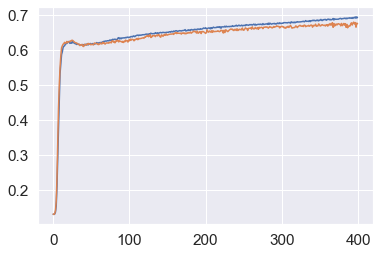

In [79]:
import matplotlib.pyplot as plt
#plot the accuracy arcoding to the epochs
plt.plot(epochs,accuracies)
plt.plot(epochs,val_accuracies)
print(max(accuracies))
print(max(val_accuracies))

0.6945315422415733
tensor(0.7482)


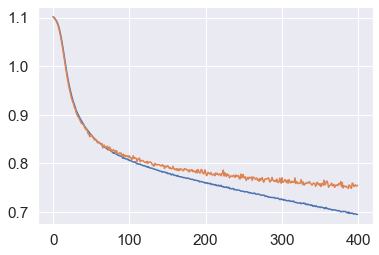

In [80]:
import matplotlib.pyplot as plt
#plot the error acording to the epochs
plt.plot(epochs,losses)
plt.plot(epochs,val_losses)
print(min(losses))
print(min(val_losses))

In [81]:
#make predictions for the validation set
with torch.no_grad():
    val_pred=model(val_x)
    soft_val_pred=torch.softmax(val_pred, dim = 1)
    print(val_pred)
    print(multiclass_accuracy(val_pred,val_y))

tensor([[-0.6015,  1.0595, -0.5614],
        [ 0.8046, -0.8734,  0.1729],
        [ 1.2861, -1.5913,  0.4852],
        ...,
        [-0.8752,  0.1390,  0.7949],
        [-0.2700, -0.3631,  0.7458],
        [ 0.7414, -1.4335,  0.8804]])
tensor(0.6770)


In [112]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report

#a function to calculate the scores given the predictions of each class and the truly label
def multiclass_scores(predictions, targets):
    y_pred_softmax = torch.log_softmax(predictions, dim = 1)
    #the label that the tweet belongs to will be the one with the highest propability
    predicts=torch.argmax(y_pred_softmax,1)
    print(classification_report(torch.squeeze(targets), predicts))
    print("Accuracy: "+ str(accuracy_score(torch.squeeze(targets),predicts)))
    print("F1_score: "+str(f1_score(torch.squeeze(targets),predicts,average='macro')))
    print("Precision: "+str(precision_score(torch.squeeze(targets),predicts,average='macro')))
    print("Recall: "+str(recall_score(torch.squeeze(targets),predicts,average='macro')))


multiclass_scores(val_pred,val_y)    

              precision    recall  f1-score   support

         0.0       0.82      0.74      0.78      1065
         1.0       0.38      0.68      0.49       296
         2.0       0.70      0.60      0.64       921

    accuracy                           0.68      2282
   macro avg       0.63      0.67      0.64      2282
weighted avg       0.71      0.68      0.69      2282

Accuracy: 0.6770376862401403
F1_score: 0.6386230920102832
Precision: 0.6338177687388923
Recall: 0.6748346571097409


In [109]:
#ROC Curve calculations
from sklearn.metrics import roc_curve, auc
#acc, val_final_predicts=multiclass_accuracy_predictions(val_pred,val_y)
fpr = dict()
tpr = dict()
roc_auc = dict()

num_val_y=val_y.squeeze().numpy().astype(int)
#print(num_val_y.shape)
#making the label of validation set one-hot encoding
b_num_val_y = np.zeros((num_val_y.size, num_val_y.max()+1))
b_num_val_y[np.arange(num_val_y.size),num_val_y] = 1

for i in range(3):
    
    fpr[i], tpr[i], _ = roc_curve(b_num_val_y[:,i], soft_val_pred[:,i])
    #print(fpr[i])
    roc_auc[i] = auc(fpr[i], tpr[i])

[[0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]


In [ ]:
from itertools import cycle
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
plt.figure(figsize = (10,7))
for i, color in zip(range(3), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i])
    )
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()    

[[791 102 172]
 [ 27 202  67]
 [148 221 552]]


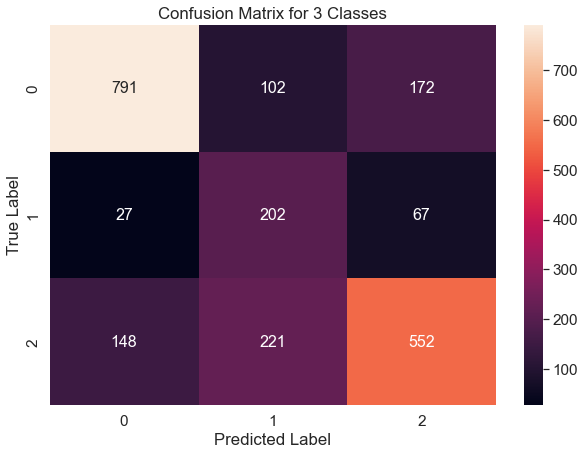

In [114]:
#The confusion matrix of my predictions
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn

val_max=torch.argmax(soft_val_pred, dim=1)
cm=confusion_matrix( y_true=val_y.squeeze(1), y_pred=val_max,labels=[0,1,2])
print(cm)
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(cm, annot=True, annot_kws={"size": 16},fmt='g') # font size
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title("Confusion Matrix for 3 Classes")
plt.show()